# Simulating Background ELGs

* keep exploring the code, options, etc.
* build a single BGS target at, say, a redshift of 0.2. play around with the seed to get a galaxy without strong emission lines (i.e., an early-type galaxy); there’s no trivial way to do this right now, but we can work on that separately
* build another emission-line galaxy at a different, higher redshift (say, z=0.8) using the ELG().make_template method.
* add the two spectra together (in the observed frame) with some flux-ratio, which should be an input variable.
* simulate a noisy DESI Spectrum
* run redrock on the resulting spectrum, which should hopefully yield the redshift of the foreground BGS target
* subtract the best-fitting redrock template from the data, which should yield a (noisy) emission-line spectrum of the background galaxy.
* run redrock on that //residual// spectrum and you will hopefully find(!) the background emission-line galaxy!

## Imports

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import fitsio

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.scripts.quickspectra import sim_spectra
from desisim.templates import BGS, ELG

import redrock.templates
 
from desi_myfunctions import *

%matplotlib inline

## Functions

In [2]:
# Check if the outfile exists and if not run the input command

def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd

# Find second magnitude based on flux ratio and first magnitude        
        
def maggen(mag, fratio=1):
    
    newmag = -2.5*np.log10(fratio)+mag
    
    return newmag

# Simulate and combine an ELG and BGS spectra based on given seeds and red shifts

def combspec(ELGmag, BGSmag, ELGseed, BGSseed, rShifts, returnmeta=False):
    
    makeBGS = BGS()
    makeELG = ELG()
    shift1 = [rShifts[0]]
    shift2 = [rShifts[1]]

    fluxBGS, waveBGS, metaBGS, objmetaBGS = makeBGS.make_templates(seed=BGSseed, nmodel=1, redshift=shift1, mag=BGSmag, nocolorcuts=True)
    fluxELG, waveELG, metaELG, objmetaELG = makeELG.make_templates(seed=ELGseed, nmodel=1, redshift=shift2, mag=ELGmag, nocolorcuts=True)
    
    wave = waveBGS
    flux = fluxBGS + fluxELG
    
    if returnmeta == True:
        return wave, flux, metaBGS, metaELG
    
    else:
        return wave, flux

## Select Spectra, Simulate, and Combine

In [3]:
BGSseed = 24
rshift = [0.2, 0.8]
BGSmag = [20]
ELGseed = 15
fratio = 0.015
ELGmag = maggen(BGSmag, fratio)

combwave, combflux, BGSmeta, ELGmeta = combspec(ELGmag, BGSmag, ELGseed, BGSseed, rshift, returnmeta=True)

INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits


In [4]:
fileloc = os.path.join(os.getenv('HOME'), 'learning', 'fitsfiles', 'background_elg_sim')

writefits(fileloc, name='comb-spec-data', data=combwave, unit='Angstrom', hdrname='Wavelength', overwrite=True)
writefits(fileloc, name='comb-spec-data', data=combflux, unit='10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=True)

In [5]:
infile = os.path.join(fileloc, 'comb-spec-data.fits')
outfile = os.path.join(fileloc, 'comb-obsspectra')

cmd = 'quickspectra -i {} -o {} --moonsep 100 --airmass 2.0 --moonfrac .6 --exptime 100 --seeing 2.0'.format(infile, outfile)

chkfile(cmd, outfile, overwrite=False)

## Run Combined Simulated spectra through Redrock

In [6]:
rroutfile = os.path.join(fileloc, 'rr-comb-data')

cmd = 'rrdesi {} -z {}'.format(outfile, rroutfile)

chkfile(cmd, rroutfile, overwrite=False)

zbest = Table.read(rroutfile, 'ZBEST')

zbest['Z']

0.20040926537509116


# Simulate a Redrock Template and find Residual ELG Flux

In [7]:
file = redrock.templates.find_templates()[0]
rrtemp = redrock.templates.Template(file, wave=combwave)

ncoeff = rrtemp.flux.shape[0]
coeff = zbest['COEFF'][0][:ncoeff]

tempflux = rrtemp.flux.T.dot(coeff)
tempwave = rrtemp.wave * (1+zbest['Z'])

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


In [21]:
spectra = desispec.io.read_spectra(outfile)

ivarb = fits.getdata(outfile, 'B_IVAR')
ivarr = fits.getdata(outfile, 'R_IVAR')
ivarz = fits.getdata(outfile, 'Z_IVAR')
ivar = {'b': ivarb, 'r': ivarr, 'z': ivarz}

maskb = fits.getdata(outfile, 'B_MASK')
maskr = fits.getdata(outfile, 'R_MASK')
maskz = fits.getdata(outfile, 'Z_MASK')
mask = {'b': maskb, 'r': maskr, 'z': maskz}

resb = fits.getdata(outfile, 'B_RESOLUTION')
resr = fits.getdata(outfile, 'R_RESOLUTION')
resz = fits.getdata(outfile, 'Z_RESOLUTION')
res = {'b': resb, 'r': resr, 'z': resz}

spectra_fibermap = Table.read(outfile, 'FIBERMAP')

print(len(spectra_fibermap))

print(res['b'][0].shape)

specdata = None

for band in spectra.bands:
    
    R = Resolution(spectra.resolution_data[band][0])
    txflux = R.dot(resample_flux(spectra.wave[band], tempwave, tempflux))
    
    spec = Spectra([band], {band : spectra.wave[band]}, {band : spectra.flux[band] - txflux}, ivar, 
                resolution_data=res, 
                mask=mask, 
                fibermap=spectra_fibermap, 
                meta=None,
                single=True)
    
    if specdata is None:
        specdata = spec
        
    else:
        specdata.update(spec)

1
(9, 2380)


In [9]:
residualoutfile = os.path.join(fileloc, 'residualdata-spectra-class')
rrsuboutfile = os.path.join(fileloc, 'rr-rerun-subtracted')

desispec.io.write_spectra(outfile=residualoutfile, spec=specdata)

cmd = 'rrdesi {} -z {}'.format(residualoutfile, rrsuboutfile)

chkfile(cmd, rrsuboutfile, overwrite=False)

In [10]:
reszbest = Table.read(rrsuboutfile, "ZBEST")
reszbest['Z']

0.7031685309056394


DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


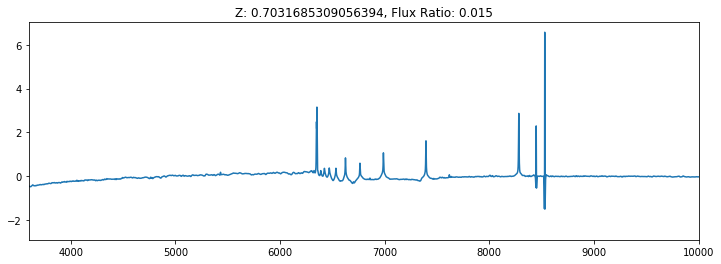

In [11]:
ELGfile = redrock.templates.find_templates()[0]
rrELGtemp = redrock.templates.Template(ELGfile, wave=combwave)

nELGcoeff = rrELGtemp.flux.shape[0]
ELGcoeff = reszbest['COEFF'][0][:nELGcoeff]

ELGtempflux = rrELGtemp.flux.T.dot(ELGcoeff)
ELGtempwave = rrELGtemp.wave * (1+reszbest['Z'])

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.set_title('Z: {}, Flux Ratio: {}'.format(reszbest['Z'][0], fratio))
ax.set_xlim(3600,10000)
ax.plot(ELGtempwave, ELGtempflux)
        

# Generalize this into one for loop

In [12]:
'''bestfratio = {'FLUX_RATIO': [], 'ZBEST': []}

fratios = np.arange(.01, .11, .01)
BGSseed = 237583
rshift = [0.2, 0.8]
BGSmag = [20]
ELGseed = 2

fileloc = os.path.join(os.getenv('HOME'), 'learning', 'fitsfiles', 'background_elg_sim')

for fratio in fratios:
    
    infile = os.path.join(fileloc, 'comb-spec-data-{}.fits'.format(fratio))
    outfile = os.path.join(fileloc, 'comb-obsspectra-{}'.format(fratio))
    rroutfile = os.path.join(fileloc, 'rr-comb-data-{}'.format(fratio))
    residualoutfile = os.path.join(fileloc, 'residualdata-spectra-class-{}'.format(fratio))
    rrsuboutfile = os.path.join(fileloc, 'rr-rerun-subtracted-{}'.format(fratio))
    
    ELGmag = maggen(BGSmag, fratio)
    
    combwave, combflux, BGSmeta, ELGmeta = combspec(ELGmag=ELGmag, BGSmag=BGSmag, ELGseed=ELGseed, BGSseed=BGSseed, rShifts=rshift, returnmeta=True);

    writefits(fileloc, name='comb-spec-data-{}'.format(fratio), data=combwave, unit='Angstrom', hdrname='WAVELENGTH', overwrite=True)
    writefits(fileloc, name='comb-spec-data-{}'.format(fratio), data=combflux, unit='10^-17 erg/(s*cm^2*Angstrom)', hdrname='FLUX', overwrite=True)
    
    cmd = 'quickspectra -i {} -o {} --moonsep 100 --airmass 2.0 --moonfrac .6 --exptime 100 --seeing 2.0'.format(infile, outfile)
    chkfile(cmd, outfile, overwrite=False)

    cmd = 'rrdesi {} -z {}'.format(outfile, rroutfile)
    chkfile(cmd, rroutfile, overwrite=False)
    
    zbest = Table.read(rroutfile, 'ZBEST')
    
    file = redrock.templates.find_templates()[0]
    rrtemp = redrock.templates.Template(file, wave=combwave)

    ncoeff = rrtemp.flux.shape[0]
    coeff = zbest['COEFF'][0][:ncoeff]

    tempflux = rrtemp.flux.T.dot(coeff)
    tempwave = rrtemp.wave * (1+zbest['Z'])
    
    spectra = desispec.io.read_spectra(outfile)

    ivarb = fits.getdata(outfile, 'B_IVAR')
    ivarr = fits.getdata(outfile, 'R_IVAR')
    ivarz = fits.getdata(outfile, 'Z_IVAR')
    ivar = {'b': ivarb, 'r': ivarr, 'z': ivarz}

    maskb = fits.getdata(outfile, 'B_MASK')
    maskr = fits.getdata(outfile, 'R_MASK')
    maskz = fits.getdata(outfile, 'Z_MASK')
    mask = {'b': maskb, 'r': maskr, 'z': maskz}

    resb = fits.getdata(outfile, 'B_RESOLUTION')
    resr = fits.getdata(outfile, 'R_RESOLUTION')
    resz = fits.getdata(outfile, 'Z_RESOLUTION')
    res = {'b': resb, 'r': resr, 'z': resz}

    spectra_fibermap = Table.read(outfile, 'FIBERMAP')
    specdata = None

    for band in spectra.bands:

        R = Resolution(spectra.resolution_data[band][0])
        txflux = R.dot(resample_flux(spectra.wave[band], tempwave, tempflux))

        spec = Spectra([band], {band : spectra.wave[band]}, {band : spectra.flux[band] - txflux}, ivar, 
                    resolution_data=res, 
                    mask=mask, 
                    fibermap=spectra_fibermap, 
                    meta=None,
                    single=True)

        if specdata is None:
            specdata = spec

        else:
            specdata.update(spec)
            
    desispec.io.write_spectra(outfile=residualoutfile, spec=specdata)

    cmd = 'rrdesi {} -z {}'.format(residualoutfile, rrsuboutfile)
    chkfile(cmd, rrsuboutfile, overwrite=False)
    
    reszbest = Table.read(rrsuboutfile, "ZBEST")
    
    ELGfile = redrock.templates.find_templates()[0]
    rrELGtemp = redrock.templates.Template(ELGfile, wave=combwave)

    nELGcoeff = rrELGtemp.flux.shape[0]
    ELGcoeff = reszbest['COEFF'][0][:nELGcoeff]

    ELGtempflux = rrELGtemp.flux.T.dot(ELGcoeff)
    ELGtempwave = rrELGtemp.wave * (1+reszbest['Z'])

    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(ELGtempwave, ELGtempflux)
    ax.set_xlim(3600, 10000)
    ax.set_title('Flux Ratio: {0:.3f}, ELG Z: {1}'.format(fratio, reszbest['Z'][0]))
    
    if reszbest['Z'] > 0.65 and reszbest['Z'] < 0.95:
        
        bestfratio['FLUX_RATIO'].append(fratio)
        bestfratio['ZBEST'].append(reszbest['Z'])'''

'bestfratio = {\'FLUX_RATIO\': [], \'ZBEST\': []}\n\nfratios = np.arange(.01, .11, .01)\nBGSseed = 237583\nrshift = [0.2, 0.8]\nBGSmag = [20]\nELGseed = 2\n\nfileloc = os.path.join(os.getenv(\'HOME\'), \'learning\', \'fitsfiles\', \'background_elg_sim\')\n\nfor fratio in fratios:\n    \n    infile = os.path.join(fileloc, \'comb-spec-data-{}.fits\'.format(fratio))\n    outfile = os.path.join(fileloc, \'comb-obsspectra-{}\'.format(fratio))\n    rroutfile = os.path.join(fileloc, \'rr-comb-data-{}\'.format(fratio))\n    residualoutfile = os.path.join(fileloc, \'residualdata-spectra-class-{}\'.format(fratio))\n    rrsuboutfile = os.path.join(fileloc, \'rr-rerun-subtracted-{}\'.format(fratio))\n    \n    ELGmag = maggen(BGSmag, fratio)\n    \n    combwave, combflux, BGSmeta, ELGmeta = combspec(ELGmag=ELGmag, BGSmag=BGSmag, ELGseed=ELGseed, BGSseed=BGSseed, rShifts=rshift, returnmeta=True);\n\n    writefits(fileloc, name=\'comb-spec-data-{}\'.format(fratio), data=combwave, unit=\'Angstrom\', 

In [13]:
bestfratio

NameError: name 'bestfratio' is not defined